## Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import warnings
import urllib.request
import json
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from random import randint
from matplotlib import rcParams

## Load Data Function

In [2]:
def load_data(start_year, end_year, parameter):
    year = start_year - 1
    size = (end_year - start_year + 1) * 12
    month = 1
    x = [[]for i in range (size)]
    for i in range(0, size):
        year = year + 1 if ((i + 1) % 12) == 1 else year
        ms = '0' + str(month) if month<10 else str(month)
        filename = 'v' + parameter + str(year) + ms + '01' + '.txt'
        path = path = '~/Documents/Tesis/Data/' + parameter + '/' + str(year) + '/'
        x[i] = pd.read_csv(path + filename, header=None)
        month = month + 1 if month < 12 else 1
    return x

## Get Latitude and Longitude Functions

In [3]:
def findItem(theList, item):
    pos_list = [[ind, theList[ind].index(item)] for ind in range(len(theList)) if item in theList[ind]]
    return [pos_list[0][0], pos_list[0][1]]

def find_step(start, end, abs_step):
    act_step = abs(abs_step) if start < end else -abs(abs_step)
    return act_step

def create_list(start_lat, end_lat, start_lon, end_lon, lat_step, lon_step):
    lat = np.arange(start_lat, end_lat + lat_step, lat_step).tolist()
    lon = np.arange(start_lon, end_lon + lon_step, lon_step).tolist()
    grid = [[[]for i in range(len(lon))] for j in range(len(lat))]
    y = 0
    for i in range(0, len(lat)):
        for j in range(0, len(lon)):
            grid[i][j] = y
            y += 1
    return grid, lat, lon

def get_ll(index, grid, lat_list, lon_list):
    return lat_list[findItem(grid, index)[0]], lon_list[findItem(grid, index)[1]]

def get_index(latitude, longitude, grid, lat_list, lon_list):
    longitude = longitude + 180
    return grid[lat_list.index(latitude)][lon_list.index(longitude)]

# print(get_ll(619683))
# print(get_index(-30.75,14))

## Get Elevation Function

In [ ]:
def get_elevation(lat, lon):
    key = 'Ai9NLeGblweg0P_Br_bKnbLVkkRgbG6RlH4k5FrbBctSqD32KHMuFQmRyX-apadI'
    url = 'https://dev.virtualearth.net/REST/v1/Elevation/List?key=' + key + '&points=' + str(lat) + ',' + str(lon)
    response = urllib.request.urlopen(url)
    data = json.loads(response.read().decode())
    elevation = data['resourceSets'][0]['resources'][0]['elevations'][0]
    return [elevation, elevation / 1000]

## ARIMA Function

In [4]:
def arima_model(data, numpr):
    X = data
    actual_size = len(data)
    train_size = int(0.75*len(data))
    train = X[0:train_size]
    test = X[train_size - 1:]
    
    best_aic = 99999
    p=(3,4,6)
    # p=(6,12)
    d=range(0,1)
    q=range(1,5)
    pdq = list(itertools.product(p, d, q))
    
    warnings.filterwarnings('ignore')
    for param in pdq:
        try:
            model_arima = ARIMA(train, order = param)
            model_arima_fit = model_arima.fit()
            aic = model_arima_fit.aic
            print(param, aic)
            if aic < best_aic:
                best_aic = aic
                best_pdq = param
                best_fit = model_arima_fit
        except:
            continue    
    
    model_arima = ARIMA(train, order=best_pdq)
    # model_arima_fit = model_arima.fit()
    aic = best_fit.aic
    predictions = best_fit.forecast(steps=(actual_size - train_size + 1 + numpr))[0]
    mse = mean_squared_error(test, predictions[0:len(test)])
    return predictions, train, test, aic, mse, best_pdq

## Data Loading

In [5]:
start_time = time.time()
tcwv_data = load_data(1979, 2019, 'tclw')
print("--- %s seconds ---" % (time.time() - start_time))

--- 209.49578762054443 seconds ---


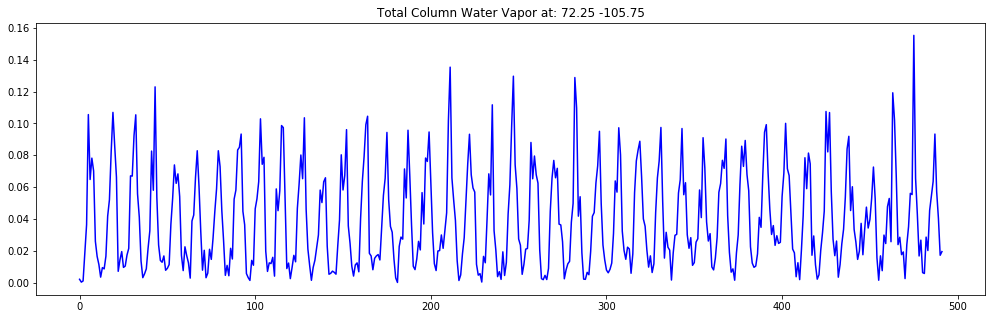

In [36]:
tcwv_values = [0] * (len(tcwv_data))
pos = randint(0, 1038239)
for i in range(len(tcwv_data)):
    tcwv_values[i] = tcwv_data[i][0].values[pos]

start_lat = 90
end_lat = -90
start_lon = 0
end_lon = 359.75
step = 0.25
lat_step = find_step(start_lat, end_lat, step)
lon_step = find_step(start_lon, end_lon, step)
    
lists = create_list(start_lat, end_lat, start_lon, end_lon, lat_step, lon_step)
grid_list = lists[0]
lat_list = lists[1]
lon_list = lists[2]
rcParams['figure.figsize'] = 17, 5

plt.plot(tcwv_values, 'b')
latstr = str(get_ll(pos, grid_list, lat_list, lon_list)[0])
lonstr = str(get_ll(pos, grid_list, lat_list, lon_list)[1] - 180)
# print('At position:', latstr, lonstr)
title = 'Total Column Water Vapor at: ' + latstr + ' ' + lonstr
plt.title(title)
# plt.savefig('figure.png')
plt.show()

(3, 0, 2) -2045.6740395106876
(3, 0, 3) -2039.3372347831
(3, 0, 4) -2042.8356420093937
(4, 0, 1) -1946.5580754981252
(4, 0, 2) -2048.0852100860798
(4, 0, 3) -2051.5369397458253
(4, 0, 4) -2069.619080613439
(6, 0, 1) -1960.607388389244
(6, 0, 2) -2059.3034359532403
(6, 0, 3) -2053.3078375890186
(6, 0, 4) -2040.8814566686665


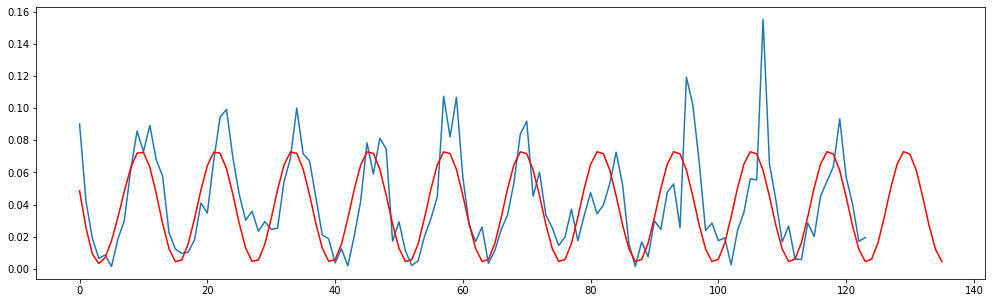

P, D, Q (4, 0, 4)
AIC: -2069.619080613439
MSE: 0.00047430369782782404


In [37]:
arima_func = arima_model(tcwv_values, 12)
predictions = arima_func[0]
train = arima_func[1]
test = arima_func[2]
aic = arima_func[3]
mse = arima_func[4]
best_pdq = arima_func[5]
str_i = 'AIC: ' + str(aic) + '\nMSE: ' + str(mse)

plt.plot(test)
plt.plot(predictions, 'r')
plt.show()

print('P, D, Q', best_pdq)
print(str_i)

In [38]:
def find_lat(lat_list, any_lat, step):
    lat = min(lat_list, key=lambda x: abs(x - any_lat))
    if any_lat - lat < 0:
        lat_t = lat
        lat_b = lat - step
    else:
        lat_t = lat + step
        lat_b = lat
    return lat_b, lat_t

def find_lon(lon_list, any_lon, step):
    any_lon = any_lon + 180
    lon = min(lon_list, key=lambda x: abs(x - any_lon))
    if any_lon - lon < 0:
        lon_r = lon
        lon_l = lon - step
    else:
        lon_r = lon + step
        lon_l = lon
    return lon_l, lon_r, lon_l - 180, lon_r -180
'''
cv_lat = find_lat(lat_list, 17.36, step)
cv_lon = find_lon(lon_list, -61.29, step)
print('Bottom Latitude', cv_lat[0], 'Top Latitude', cv_lat[1])
print('Left Longitude', cv_lon[2], 'Right Longitude', cv_lon[3])
'''

"\ncv_lat = find_lat(lat_list, 17.36, step)\ncv_lon = find_lon(lon_list, -61.29, step)\nprint('Bottom Latitude', cv_lat[0], 'Top Latitude', cv_lat[1])\nprint('Left Longitude', cv_lon[2], 'Right Longitude', cv_lon[3])\n"

In [45]:
def interp(lat, lon, month, year, parameter, grid, lat_list, lon_list, step):
    ms = '0' + str(month) if month<10 else str(month)
    filename = 'v' + parameter + str(year) + ms + '01' + '.txt'
    path = path = '~/Documents/Tesis/Data/' + parameter + '/' + str(year) + '/'
    data = pd.read_csv(path + filename, header=None)
    if (lat % 0.25) == 0 and (lon % 0.25) == 0:
        pos = get_index(lat, lon, grid, lat_list, lon_list)
        return data[0].values[pos]
    else:
        cv_lat = find_lat(lat_list, lat, step)
        cv_lon = find_lon(lon_list, lon, step)
        lat_0 = cv_lat[0]
        lat_1 = cv_lat[1]
        lon_a = cv_lon[2]
        lon_b = cv_lon[3]
        tl = get_index(lat_1, lon_a, grid, lat_list, lon_list)
        tr = tl + 1# get_index(lat_1, lon_b, grid, lat_list, lon_list)
        bl = tl + 1440# get_index(lat_0, lon_a, grid, lat_list, lon_list)
        br = bl + 1# get_index(lat_0, lon_b, grid, lat_list, lon_list)
        t = (lat - lat_0) / (lat_1 - lat_0)
        s = (lon - lon_a) / (lon_b - lon_a)
        X_tl = data[0].values[tl]
        X_tr = data[0].values[tr]
        X_bl = data[0].values[bl]
        X_br = data[0].values[br]
        value = (1 - s) * (1 - t) * X_bl + (1 - s) * t * X_tl + s * (1 - t) * X_br + t * s * X_tr
        # print([lat_1, lon_a + 180], [lat_1, lon_b + 180], '\n', [lat_0, lon_a + 180], [lat_0, lon_b + 180])
        print(X_tl, X_tr, '\n', X_bl, X_br)
        # print([lat_1, lon_a], [lat_1, lon_b], '\n', [lat_0, lon_a], [lat_0, lon_b])
        # print(tl, tr, '\n', bl, br)
        return value       

# interp(-17.35, -98.69, 1, 1985, 'tcwv', grid_list, lat_list, lon_list, step)
interp(35.81125, -61.92543, 9, 1985, 'tclw', grid_list, lat_list, lon_list, step)

0.17855834961 0.17997741699 
 0.17909240723 0.18116760254


0.1795326034596215